## Association rule

### 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
# 과제 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/fastcampus_python/data/online_commerce_data.csv')
df.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147311 entries, 0 to 147310
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_no      147311 non-null  int64  
 1   age              147273 non-null  float64
 2   gender           147311 non-null  int64  
 3   order_no         147311 non-null  int64  
 4   order_date       147311 non-null  object 
 5   channel          147311 non-null  object 
 6   item_category    147311 non-null  object 
 7   item_code        147311 non-null  int64  
 8   item_name        147311 non-null  object 
 9   price            147311 non-null  int64  
 10  qty              147311 non-null  int64  
 11  order_amount     147311 non-null  int64  
 12  discount_amount  147311 non-null  int64  
 13  paid_amount      147311 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 15.7+ MB


In [ ]:
# 샘플 데이터 확인
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_no,age,gender,order_no,order_date,channel,item_category,item_code,item_name,price,qty,order_amount,discount_amount,paid_amount
0,2021059651101,68.0,9,202106072433746,2021/06/07,TV,캐쥬얼,323421750,밴딩팬츠,49900,1,49900,4990,44910
1,2018069800502,49.0,2,202105311957155,2021/05/31,TV,레포츠패션,323516657,트랙수트,39000,1,39000,1000,38000
2,2019073300103,35.0,1,202105138020462,2021/05/13,TV,뷰티,323393459,기초세트,72000,2,144000,27600,116400
3,2020075283364,41.0,9,202106171444319,2021/06/17,TV,건강식품,323420069,유산균,119000,2,238000,72920,165080
4,2020104780765,46.0,1,202106024431989,2021/06/02,TV,일반식품,321820178,건강주스,45900,1,45900,2290,43610


### 네트워크 그래프를 이용한 판매 Top 30 아이템 탐색

In [ ]:
! pip install --index-url https://test.pypi.org/simple/ PyARMViz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://test.pypi.org/simple/


In [ ]:
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from PyARMViz import PyARMViz

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

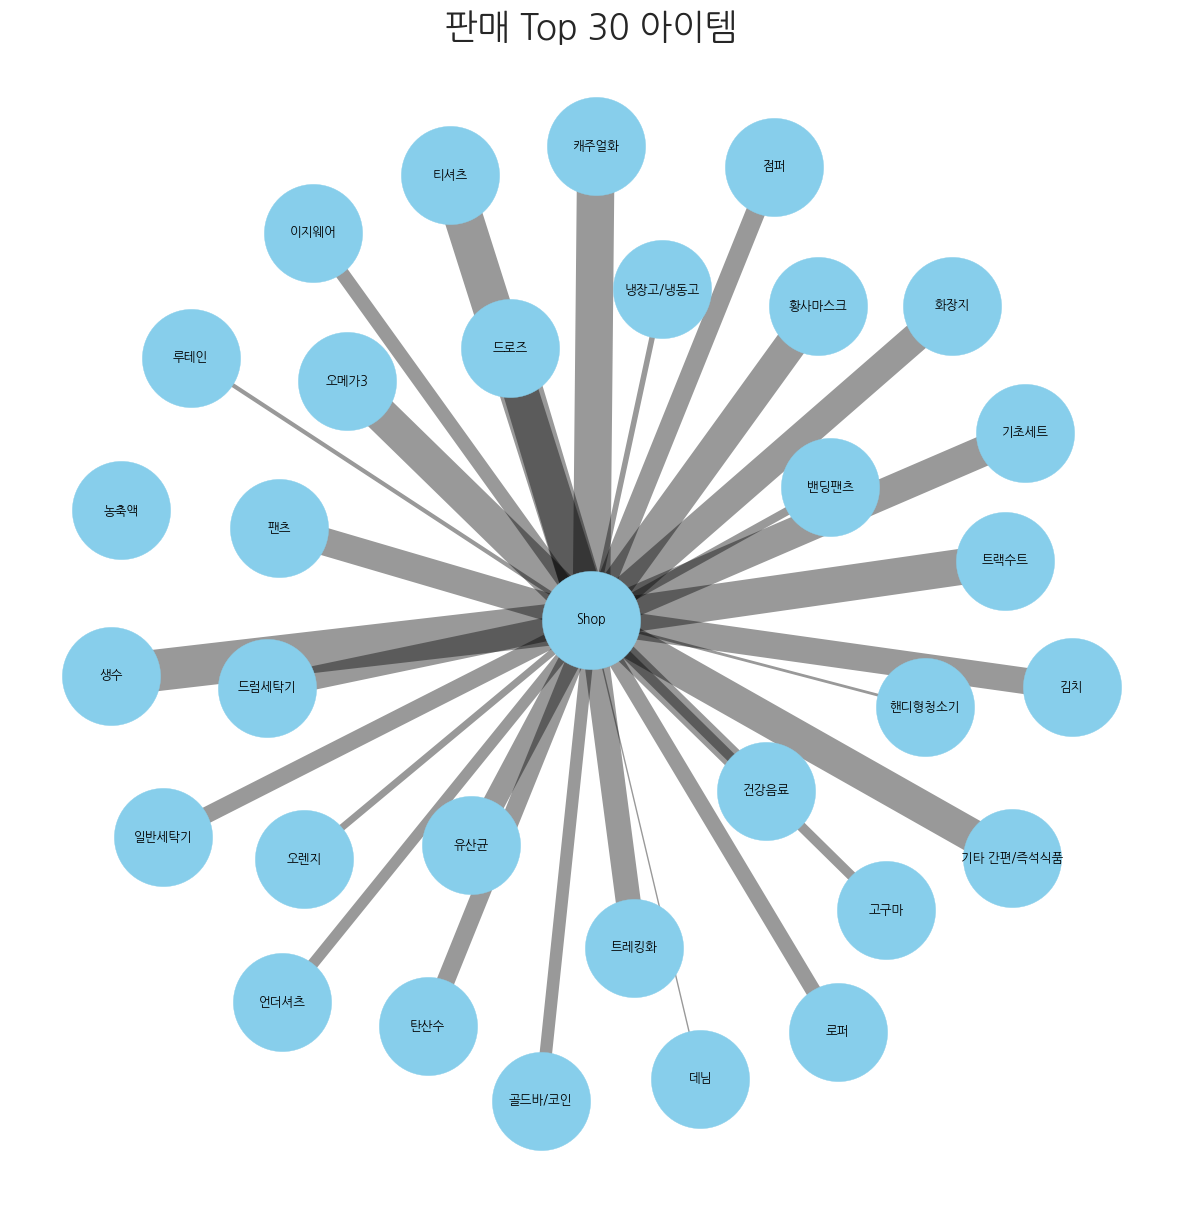

In [ ]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

data_vis = df.copy()
df_network_first = data_vis.groupby("item_name").sum().sort_values("order_no", ascending=False).reset_index()
df_network_first["Type"] = "Shop"
df_network_first = df_network_first.truncate(before=-1, after=30) # top 30
plt.rcParams['figure.figsize']=(15,15)
j = 0
for i, _ in reversed(list(enumerate(df_network_first['order_no']))):
    df_network_first['order_no'][j] = i
    j+=1
first_choice = nx.from_pandas_edgelist(df_network_first, source='Type', target="item_name", edge_attr='order_no')
prior = [i['order_no'] for i in dict(first_choice.edges).values()]
pos = nx.spring_layout(first_choice)
nx.draw_networkx_nodes(first_choice, pos, node_size=5000, node_color="skyblue")
nx.draw_networkx_edges(first_choice, pos, width=prior, alpha=0.4, edge_color='black')
nx.draw_networkx_labels(first_choice, pos, font_size=9, font_family='NanumGothic', font_color = 'black')
plt.axis('off')
plt.grid()
plt.title('판매 Top 30 아이템', fontsize=25)
plt.show()

### 연관규칙 적용을 위한 데이터 준비

In [ ]:
# 연관 규칙 분석에 필요한 컬럼만 선택하여 다시 객체 지정하기
df = df[['customer_no', 'item_code', 'item_name']]
df.head()

,customer_no,item_code,item_name
0,2021059651101,323421750,밴딩팬츠
1,2018069800502,323516657,트랙수트
2,2019073300103,323393459,기초세트
3,2020075283364,323420069,유산균
4,2020104780765,321820178,건강주스


과제 데이터 중 고객을 식별하는 `customer_no`, `item_code`, `item_name` 정보만을 다시 df 객체로 Assign 합니다.<br>
이 과제에서는 각 고객이 구매한 품목들을 하나의 장바구니로 가정하겠습니다.

In [ ]:
# apriori 모델 적용을 위한 품목 리스트 가공
itemset = df.drop_duplicates(
    ['customer_no', 'item_name']).groupby(['customer_no'])['item_name'].apply(list)

itemset = pd.DataFrame(itemset).reset_index().drop(['customer_no'], axis = 'columns')

itemset = itemset.squeeze()

itemset.head()

0                    [도가니탕, 혈당/혈압측정기]
1                              [이온음료]
2    [닭고기(계육), 크리스피롤, 오메가3, 도가니탕, 사과]
3                               [유산균]
4                              [기모팬츠]
Name: item_name, dtype: object

기존 데이터셋을 apriori 모델에 적용하기 위해 각 장바구니의 구매 품목들을 리스트 형태로 저장합니다.<br>
장바구니에서 중복된 품목은 제거한 뒤 고객-일자별로 묶어서 **`apply(list)`** 함수로 품목들을 리스트 형태로 가공합니다.



### 장바구니 리스트를 더미 형태로 변환

In [ ]:
# apriori 모델 적용을 위한 장바구니 - 품목 더미 가공

encoder = TransactionEncoder()
encoder_T = encoder.fit(itemset).transform(itemset)

# 데이터프레임으로 변경
itemset_matrix = pd.DataFrame(encoder_T, columns=encoder.columns_)

itemset_matrix.head()

,18K쥬얼리,18K쥬얼리세트,2-4단 서랍장/협탁,2-5인용텐트,2구 가스레인지,2구 이상 전기레인지,7부/9부/크롭,DIY반제품,IH압력밥솥,LA갈비,...,후라이팬24-26cm,후라이팬28cm이상,후라이팬2종세트,후라이팬세트,후지필름,훌라후프,훌라후프/짐볼,휴대폰 거치대,흑미,흑염소즙
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Apriori** 패키지에서는 리스트가 아닌 더미 가공이 된 행렬 형태의 데이터셋을 입력해야 하므로<br> **`TransactionEncoder()`** 함수를 사용하여 행렬 형태로 변환합니다. 그리고 다시 판다스 데이터 프레임 형식으로 변환합니다.

### 지지도 기준 설정 및 apriori 모델 적용

In [ ]:
# 지지도 0.0005 기준으로 apriori 적용

itemset_apriori = apriori(itemset_matrix, min_support = 0.0005, use_colnames=True)
itemset_apriori.head()

,support,itemsets
0,0.001568,(IH압력밥솥)
1,0.009006,(LA갈비)
2,0.001804,(LED TV)
3,0.001887,(가글/치약)
4,0.000944,(가발세트)


**`apriori()`** 함수를 사용하여 **apriori** 알고리즘의 연관규칙 모델을 적용합니다.<br>
**`min_support=0.0005`** 옵션을 설정하여 지지도가 0.0005 미만인 품목이나 품목 조합은 제거합니다.<br>
이 기준은 비즈니스 상황에 따라 달라질 수 있으며, 실무에서는 각 품목의 판매비중 분포, 매출 분포 등을 분석하여 의사결정을 합니다.

### 특정 향상도 이상 상품 조합 추출

In [ ]:
# 향상도 5 이상 상품 조합 추출
association_rules(itemset_apriori, metric="lift", min_threshold=5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(IH압력밥솥),(공기청정기),0.001568,0.001832,0.000749,0.477876,260.876911,0.000747,1.911746,0.997731
1,(공기청정기),(IH압력밥솥),0.001832,0.001568,0.000749,0.409091,260.876911,0.000747,1.689654,0.997995
2,(미니/업소용 전기밥솥),(IH압력밥솥),0.000708,0.001568,0.000513,0.725490,462.644456,0.000512,3.637145,0.998545
3,(IH압력밥솥),(미니/업소용 전기밥솥),0.001568,0.000708,0.000513,0.327434,462.644456,0.000512,1.485790,0.999406
4,(IH압력밥솥),(일반압력밥솥),0.001568,0.001527,0.001291,0.823009,539.145615,0.001288,5.641375,0.999713
...,...,...,...,...,...,...,...,...,...,...
233,"(드럼세탁기, 일반세탁기)","(냉장고/냉동고, 냉장고)",0.001152,0.000805,0.000513,0.445783,553.847113,0.000513,1.802896,0.999346
234,(냉장고),"(냉장고/냉동고, 드럼세탁기, 일반세탁기)",0.002026,0.000860,0.000513,0.253425,294.544852,0.000512,1.338297,0.998628
235,(냉장고/냉동고),"(드럼세탁기, 냉장고, 일반세탁기)",0.002262,0.000638,0.000513,0.226994,355.590824,0.000512,1.292825,0.999449
236,(드럼세탁기),"(냉장고/냉동고, 냉장고, 일반세탁기)",0.001915,0.000611,0.000513,0.268116,439.100791,0.000512,1.365502,0.999637


### 특정 아이템(조합)명으로 데이터 조회하기

In [ ]:
# 향상도 1 이상인 것만 추출
rules = association_rules(itemset_apriori, metric="lift", min_threshold=1)
# support 값이 큰 순으로 내림차순 정렬
rules.sort_values(by='support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
23,(건강음료),(생수),0.012448,0.185096,0.008299,0.666667,3.601739,0.005995,2.444713,0.731462
22,(생수),(건강음료),0.185096,0.012448,0.008299,0.044834,3.601739,0.005995,1.033907,0.886431
82,(드로즈),(생수),0.031071,0.185096,0.008146,0.262171,1.416405,0.002395,1.104462,0.303415
83,(생수),(드로즈),0.185096,0.031071,0.008146,0.044010,1.416405,0.002395,1.013534,0.360763
99,(오메가3),(유산균),0.010283,0.010214,0.002262,0.219973,21.537031,0.002157,1.268913,0.963476
...,...,...,...,...,...,...,...,...,...,...
204,"(핸디형청소기, 미니/업소용 전기밥솥)",(일반압력밥솥),0.000527,0.001527,0.000513,0.973684,637.851675,0.000513,37.941993,0.998959
205,"(핸디형청소기, 일반압력밥솥)",(미니/업소용 전기밥솥),0.000958,0.000708,0.000513,0.536232,757.664109,0.000513,2.154724,0.999637
206,"(미니/업소용 전기밥솥, 일반압력밥솥)",(핸디형청소기),0.000583,0.001402,0.000513,0.880952,628.528996,0.000513,8.388226,0.998991
207,(핸디형청소기),"(미니/업소용 전기밥솥, 일반압력밥솥)",0.001402,0.000583,0.000513,0.366337,628.528996,0.000513,1.577205,0.999810


In [ ]:
# 생수 구매 시 조합 (lift 기준 내림차순 정렬)
filtered_rules = rules[(rules['antecedents'].apply(lambda x: all(item in x for item in ['생수'])) |
                        rules['consequents'].apply(lambda x: all(item in x for item in ['생수'])))]

filtered_rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
23,(건강음료),(생수),0.012448,0.185096,0.008299,0.666667,3.601739,0.005995,2.444713,0.731462
22,(생수),(건강음료),0.185096,0.012448,0.008299,0.044834,3.601739,0.005995,1.033907,0.886431
53,(생수),(나시/홈웨어),0.185096,0.002678,0.000888,0.004798,1.791539,0.000392,1.002130,0.542175
52,(나시/홈웨어),(생수),0.002678,0.185096,0.000888,0.331606,1.791539,0.000392,1.219198,0.443007
95,(생수),(스타킹 세트),0.185096,0.002567,0.000847,0.004573,1.781401,0.000371,1.002015,0.538277
94,(스타킹 세트),(생수),0.002567,0.185096,0.000847,0.329730,1.781401,0.000371,1.215785,0.439773
97,(생수),(주방세제/베이킹소다),0.185096,0.004468,0.001291,0.006973,1.560381,0.000463,1.002522,0.440703
96,(주방세제/베이킹소다),(생수),0.004468,0.185096,0.001291,0.288820,1.560381,0.000463,1.145848,0.360743
74,(둥글레/옥수수/결명자차),(생수),0.002262,0.185096,0.000624,0.276074,1.491518,0.000206,1.125673,0.330289
75,(생수),(둥글레/옥수수/결명자차),0.185096,0.002262,0.000624,0.003374,1.491518,0.000206,1.001116,0.404394


In [ ]:
# 오메가3 구매 시 조합 (support 기준 내림차순 정렬)
filtered_rules = rules[(rules['antecedents'].apply(lambda x: all(item in x for item in ['오메가3'])) |
                        rules['consequents'].apply(lambda x: all(item in x for item in ['오메가3'])))]

filtered_rules.sort_values(by='support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
98,(유산균),(오메가3),0.010214,0.010283,0.002262,0.221467,21.537031,0.002157,1.271259,0.963408
99,(오메가3),(유산균),0.010283,0.010214,0.002262,0.219973,21.537031,0.002157,1.268913,0.963476
84,(오메가3),(루테인),0.010283,0.005509,0.002123,0.206478,37.478049,0.002067,1.253261,0.983430
85,(루테인),(오메가3),0.005509,0.010283,0.002123,0.385390,37.478049,0.002067,1.610318,0.978710
70,(농축액),(오메가3),0.006286,0.010283,0.001415,0.225166,21.896667,0.001351,1.277327,0.960368
71,(오메가3),(농축액),0.010283,0.006286,0.001415,0.137652,21.896667,0.001351,1.152335,0.964246
186,"(농축액, 오메가3)",(루테인),0.001415,0.005509,0.001041,0.735294,133.464217,0.001033,3.756965,0.993914
187,"(농축액, 루테인)",(오메가3),0.001180,0.010283,0.001041,0.882353,85.806144,0.001029,8.412594,0.989513
188,"(오메가3, 루테인)",(농축액),0.002123,0.006286,0.001041,0.490196,77.976886,0.001027,1.949207,0.989276
189,(농축액),"(오메가3, 루테인)",0.006286,0.002123,0.001041,0.165563,77.976886,0.001027,1.195868,0.993421


In [ ]:
# 특정 antecedents 만 찾기
rules[rules.antecedents == frozenset({'생수'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
21,(생수),(각티슈),0.185096,0.002262,0.000569,0.003074,1.358938,0.000150,1.000814,0.324126
22,(생수),(건강음료),0.185096,0.012448,0.008299,0.044834,3.601739,0.005995,1.033907,0.886431
49,(생수),(기타 주스/음료),0.185096,0.003428,0.000666,0.003599,1.049900,0.000032,1.000172,0.058324
51,(생수),(기타 축산물),0.185096,0.003303,0.000888,0.004798,1.452802,0.000277,1.001503,0.382468
53,(생수),(나시/홈웨어),0.185096,0.002678,0.000888,0.004798,1.791539,0.000392,1.002130,0.542175
75,(생수),(둥글레/옥수수/결명자차),0.185096,0.002262,0.000624,0.003374,1.491518,0.000206,1.001116,0.404394
83,(생수),(드로즈),0.185096,0.031071,0.008146,0.044010,1.416405,0.002395,1.013534,0.360763
95,(생수),(스타킹 세트),0.185096,0.002567,0.000847,0.004573,1.781401,0.000371,1.002015,0.538277
97,(생수),(주방세제/베이킹소다),0.185096,0.004468,0.001291,0.006973,1.560381,0.000463,1.002522,0.440703


### Association rule 시각화

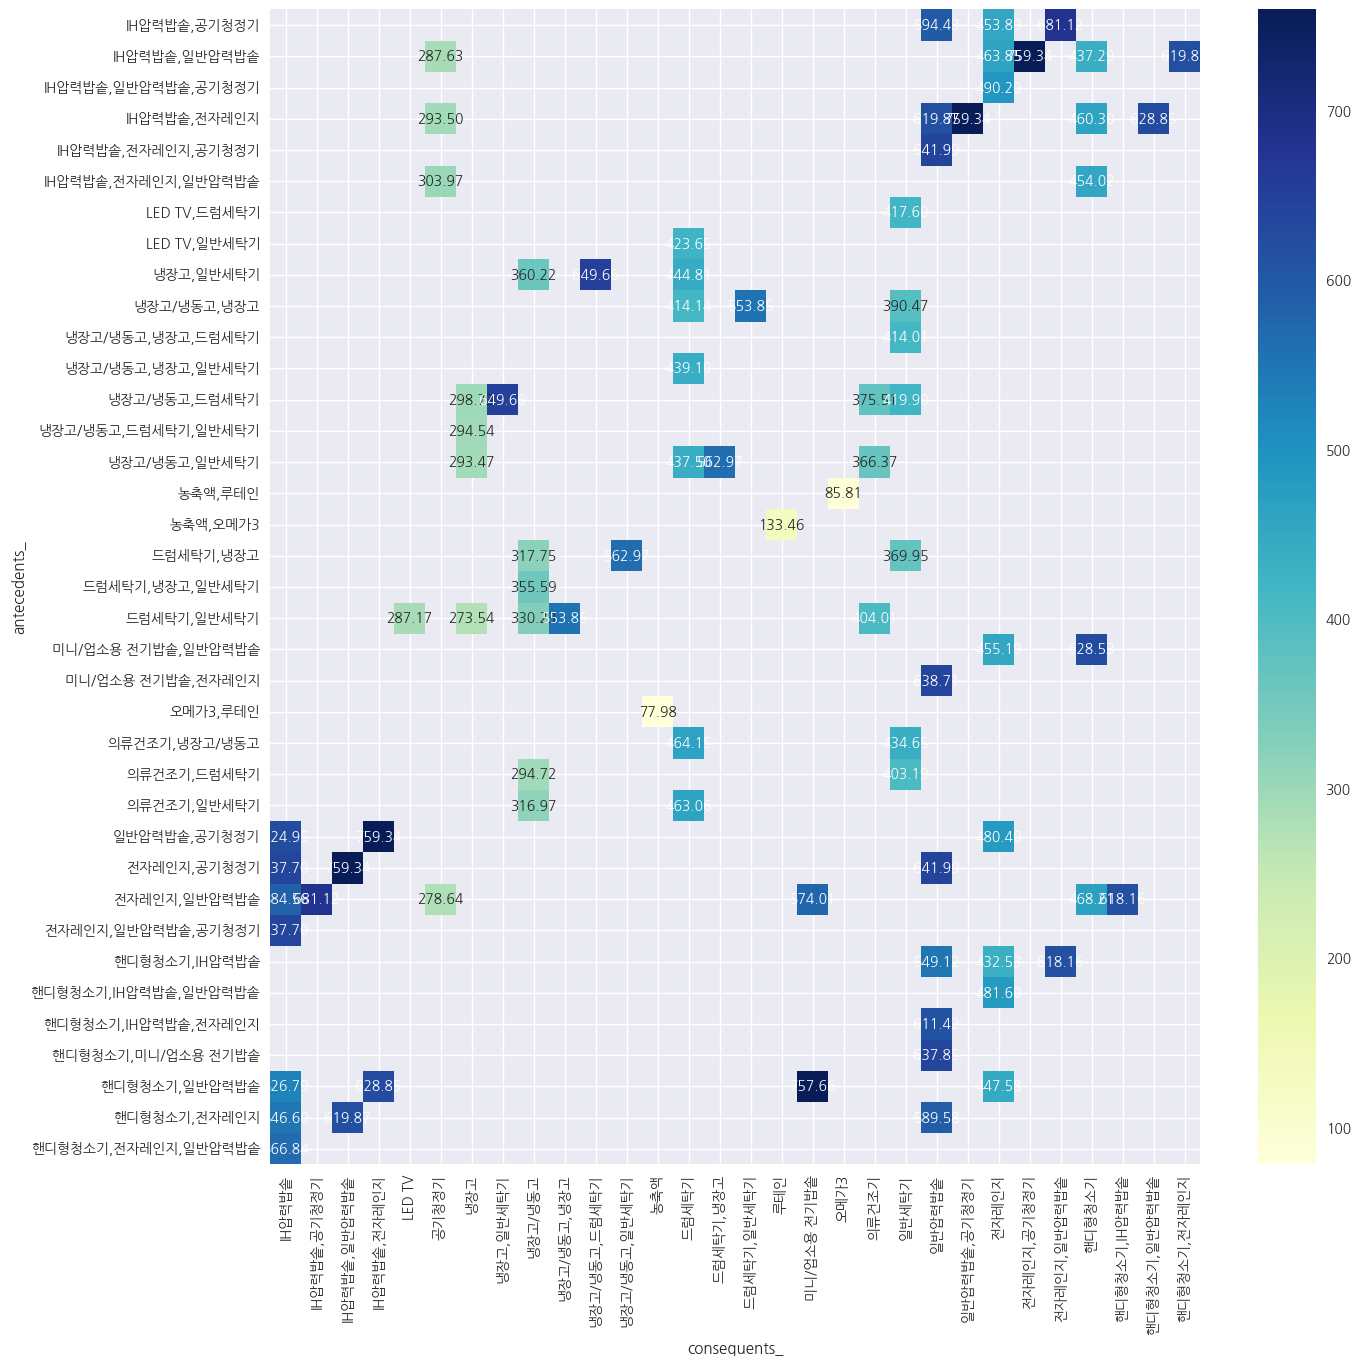

In [ ]:
rules['lhs_items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs_items']>1].sort_values('lift', ascending=False).head()
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = rules[rules['lhs_items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
sns.heatmap(pivot, annot = True, fmt=".2f", cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

아이템 조합이 2개 이상 중 최소 향상도 값이 `>=1` 것의 연관성 규칙 히트맵을 그려보면 위와 같습니다.<br>
표시된 각 value는 **향상도(lift)**를 의미하며, Y축에는 `antecedents` X축은 `consequents`를 의미합니다.

In [ ]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

apriori_vis = rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 147311

transactions = [a[1]['item_name'].tolist() for a in list(df.groupby(['customer_no']))]

def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()

rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

In [ ]:
a_rules = []
for rd in rules_dict:
    a_rules.append(generate_rule_from_dict(rd))

PyARMViz.generate_parallel_category_plot(a_rules)

수많은 연관 규칙을 보다 잘 나타내는 방법으로 **`PyARMViz`** 패키지를 사용하여 병렬(parallel) 카테고리 플롯을 그릴 수 있습니다.
<br>
이 플롯의 경우 연결 규칙 수가 많을 때 유용하며, 위에서 **향상도(lift)** 값이 `>=1` 규칙을 Antacedent의 수 순서(아이템 1개, 아이템 2개 ...)로 각 아이템이 전체 데이터에서 발생한 거래 건수를 보여줍니다.

In [ ]:
# with 0.001

f_items = apriori(itemset_matrix, min_support = 0.001, use_colnames=True)
apriori_rules = association_rules(f_items, metric = 'lift', min_threshold = 1)
apriori_rules.sort_values('confidence', ascending = False, inplace = True)

apriori_vis = apriori_rules

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 147311

transactions = [a[1]['item_name'].tolist() for a in list(df.groupby(['customer_no']))]

def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()

rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]),
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

ap_rules = []
for rd in rules_dict:
    ap_rules.append(generate_rule_from_dict(rd))

In [ ]:
PyARMViz.generate_parallel_category_plot(ap_rules)

위에서는 최소 지지도를 **`0.001`** 수준으로 설정한 연관 규칙을 시각화로 나타냈습니다.<br>
다음으로 **향상도(lift)**값이 `>=1`인 Association rule을 가지고 네트워크 그래프를 표현해줍니다.

In [ ]:
# 향상도 1 이상인 것만 추출
rules = association_rules(itemset_apriori, metric="lift", min_threshold=1)
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         258 non-null    object 
 1   consequents         258 non-null    object 
 2   antecedent support  258 non-null    float64
 3   consequent support  258 non-null    float64
 4   support             258 non-null    float64
 5   confidence          258 non-null    float64
 6   lift                258 non-null    float64
 7   leverage            258 non-null    float64
 8   conviction          258 non-null    float64
 9   zhangs_metric       258 non-null    float64
dtypes: float64(8), object(2)
memory usage: 20.3+ KB


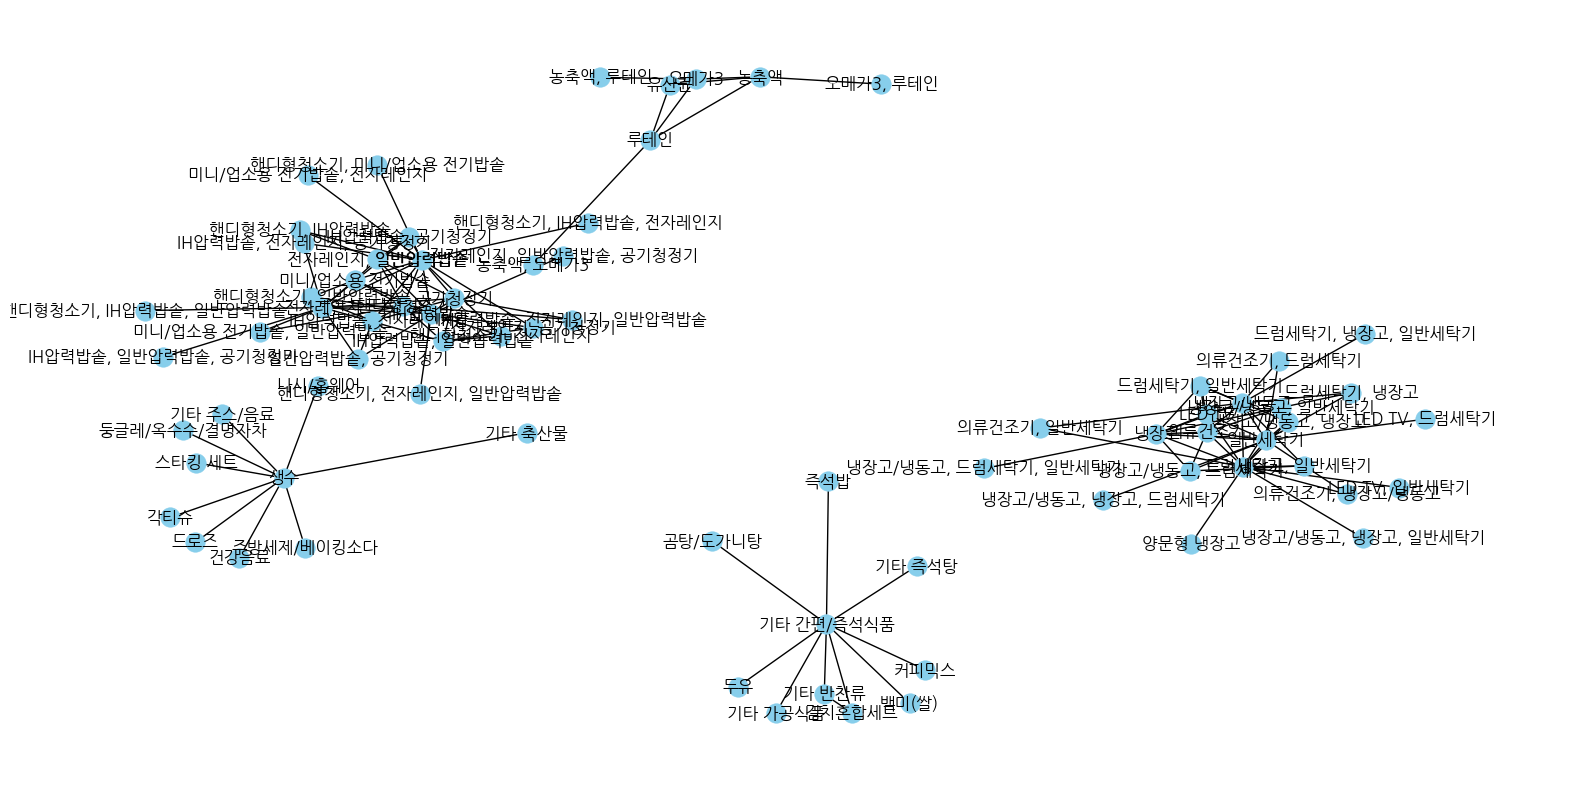

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# 그래프 생성
GA = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents', edge_attr=['support', 'confidence', 'lift'])

# 각 노드에 대한 레이블 설정 (frozenset 표기 제거)
labels = {node: ', '.join(list(node)) for node in GA.nodes}

# 레이아웃 설정 (k 값을 조정하여 간격을 조절)
pos = nx.spring_layout(GA, k=0.3)

# 그래프 그리기 (ax 매개변수를 사용하여 배경 없앰)
nx.draw_networkx(GA, pos, labels=labels, arrows=True, font_family='NanumGothic', ax=ax, node_size=200, node_color='skyblue')

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 축의 배경 없애기
ax.set_facecolor("none")

plt.show()

여러 아이템명이 겹치면서 가독성이 떨어지는 부분이 있습니다. 이를 plotly 패키지를 이용하여 동적인 plot으로 변환합니다.

In [ ]:
# plotly를 이용하여 가독성 높이기
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx

# 그래프 생성
GA = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents', edge_attr=['support', 'confidence', 'lift'])
labels = {node: ', '.join(list(node)) for node in GA.nodes}

# 그래프 레이아웃 생성
pos = nx.spring_layout(GA, k=0.3)

# 그래프 데이터 생성
edge_x = []
edge_y = []
for edge in GA.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text = []
for node in GA.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(labels[node])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        )
    )
)

# 그래프 레이아웃 설정
layout = go.Layout(
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# 그래프 생성
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]])
fig.add_trace(edge_trace, row=1, col=1)
fig.add_trace(node_trace, row=1, col=1)

# 그래프 출력
fig.update_layout(layout)
fig.show()

혹은 아래와 같이 특정 아이템을 기준으로 네트워크 그래프를 나타낼 수 있습니다.<br>

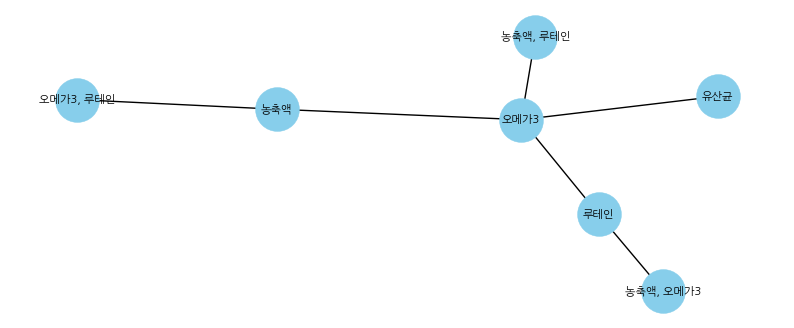

In [ ]:
# 특정 아이템 시각화 하기 (오메가3)
fig, ax = plt.subplots(figsize=(10, 4))

# 그래프 생성
GA = nx.from_pandas_edgelist(filtered_rules, source='antecedents', target='consequents')

# 각 노드에 대한 레이블 설정 (frozenset 제거)
labels = {node: ', '.join(list(node)) for node in GA.nodes}

# 레이아웃 설정
pos = nx.spring_layout(GA)

# 그래프 그리기
nx.draw(GA, pos, with_labels=False, node_size=1000, node_color='skyblue')
nx.draw_networkx_labels(GA, pos, labels=labels, font_family='NanumGothic', font_size=8, verticalalignment='center', horizontalalignment='center')

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

plt.show()